<h2>Crimes rates per Neighborhood</h2>
<p>Using data from the WRPDC, we can gauge overall criminal activity in each Pittsburgh neighborhood. This data could potentially give us an idea of which neighborhood has the most violent and experienced residents, and can help estimate the possibility of 2 emerging tributes becoming victors.</p>

<p><code>WRPDC - "Police Incident Blotter"</code>
<br>from January 2016 - present</p>
<a href='#'>https://data.wprdc.org/dataset/uniform-crime-reporting-data</a>

In [2]:
# Importing packages for data analysis
import pandas as pd
import geopandas
import numpy as np
from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("./data/crime-data.csv")

# Indexes for column names
count = 0
for i in data.columns:
    print(f"column {count}: {i}")
    count+=1

column 0: PK
column 1: CCR
column 2: HIERARCHY
column 3: INCIDENTTIME
column 4: INCIDENTLOCATION
column 5: CLEAREDFLAG
column 6: INCIDENTNEIGHBORHOOD
column 7: INCIDENTZONE
column 8: INCIDENTHIERARCHYDESC
column 9: OFFENSES
column 10: INCIDENTTRACT
column 11: COUNCIL_DISTRICT
column 12: PUBLIC_WORKS_DIVISION
column 13: X
column 14: Y


In [5]:
cols = data.INCIDENTNEIGHBORHOOD.value_counts()

# Comment out to see full data
# pd.set_option("display.max_rows", None, "display.max_columns", None)
print(cols)

South Side Flats             15069
Central Business District    13445
Carrick                       9153
Bloomfield                    7037
Shadyside                     6724
                             ...  
Chartiers City                 246
Outside State                  244
Outside County                 177
Mt. Oliver Neighborhood        117
Mt. Oliver Boro                 80
Name: INCIDENTNEIGHBORHOOD, Length: 98, dtype: int64


<h3>Cleaning our Data</h3>
<p>Now that we have a good idea of what our data looks like, we are going to have to clean it to get rid of irrelevant entries. For instance, we can get rid of 'Outside State', 'Outside County', 'Mt. Oliver Boro', etc. as they are not really neighborhoods.</p>

In [7]:
filters = [
    'Outside State',
    'Outside County', 
    'Outside City', 
    'Mt. Oliver Boro', 
    'Mt. Oliver Neighborhood', 
    'Golden Triangle/Civic Arena'
]

pattern = '|'.join(filters)

query_mask = data['INCIDENTNEIGHBORHOOD'].str.contains(pattern, na=False, case=False)==0
data = data[query_mask]
cols = data.INCIDENTNEIGHBORHOOD.value_counts() # update cols

print(cols)

South Side Flats             15069
Central Business District    13445
Carrick                       9153
Bloomfield                    7037
Shadyside                     6724
                             ...  
Swisshelm Park                 346
New Homestead                  278
Ridgemont                      259
Troy Hill-Herrs Island         252
Chartiers City                 246
Name: INCIDENTNEIGHBORHOOD, Length: 92, dtype: int64


In [8]:
# Converting our data in pandas DataFrame so we can
# merge it with geopandas and map out results
crime_by_hood = pd.DataFrame({'Neighborhood':cols.index, 'num_incidents':cols.values})
crime_by_hood.head()

,Neighborhood,num_incidents
0,South Side Flats,15069
1,Central Business District,13445
2,Carrick,9153
3,Bloomfield,7037
4,Shadyside,6724


<h3>Mapping our results</h3>
<p>Using geopandas, we can map out our results in a heat map, to get a better idea of which areas of the city are "hot" and dangerous.

In [43]:
# Checking correct map of Pittsburgh
neighborhoods = geopandas.read_file("./data/Neighborhoods/Neighborhoods_.shp")
crime_map = neighborhoods.merge(crime_by_hood, how='left', left_on="hood", right_on='Neighborhood')

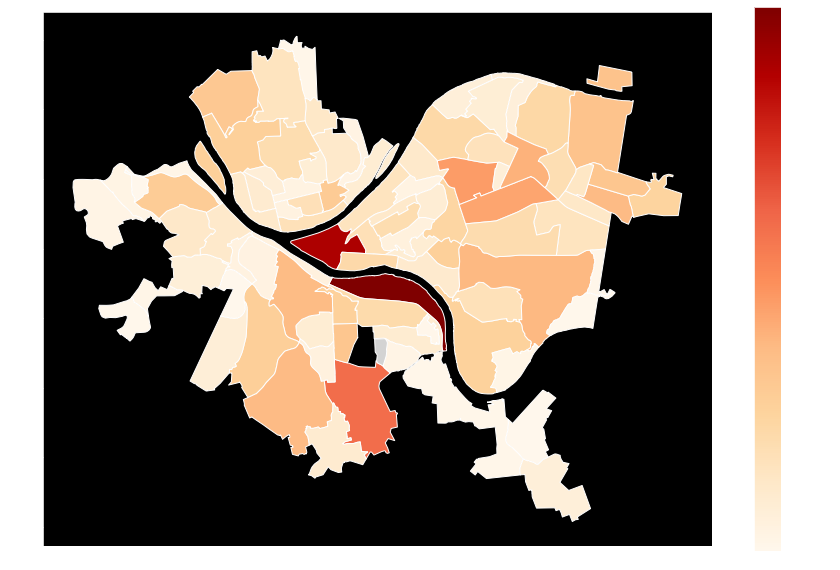

In [44]:
# Mapping crime rates to Pittsburgh with custom parameters

crime_map.plot(column='num_incidents',     # set the data to be used for coloring
               cmap='OrRd',                 # choose a color palette
               edgecolor="white",          # outline the districts in white
               legend=True,                # show the legend
               legend_kwds={'label': "Crime Rate"}, # label the legend
               figsize=(15, 10),           # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )

<h3>Map Results</h3>
<p>As we can see from our data, South Side Flats and the Central Business District have far more reported crime-related incidents than any other neighborhoods. But that doesn't paint the whole picture so we should now see if we can relate the number of reported incidents with the severity of the crime committed. This will help us gauge the ruthlessness of potential tributes. For this we can take a look at the <code>OFFENSES</code> column in our dataset.

In [14]:
crimes = data.OFFENSES.value_counts()
crime_severity = pd.DataFrame({"Offense":crimes.index, "num_incidents":crimes.values})
crime_severity.head(10)

,Offense,num_incidents
0,9999 Miscellaneous Report (No Crime),18586
1,3745 Accidents Involving Damage to Unattended ...,13698
2,3921 Theft by Unlawful Taking or Disposition.,12971
3,3304 Criminal Mischief.,12487
4,3934 Theft from Vehicle,8743
5,3743 Accidents Involving Damage to Attended Ve...,8006
6,3921(a) Theft by Unlawful Taking or Dispositio...,7976
7,2701 Simple Assault.,6940
8,3502 Burglary.,6800
9,9497 Aided Case,6026


<h3>Filtering Further</h3>
<p>As we can see from the most common offenses committed, these do not really help us determine the propensity to violence needed to survive <strong>The Hoagie Games</strong>. We will need to filter our data further to find the most terrible offenses committed in our great city and correlate the results to the neighborhood most likely to commit them.

In [16]:
# look through data to find certain codes for offenses
codes = [
    '2715', # Weapons of Mass Destruction
    '2706', # Terroristic threats
    '4953', # Mob related activity
    '8106', # Shots fired
    '2702', # Aggravated assualt
    '2501', # Criminal homicide
    '2707', # Propulsion of missiles
]

pat = '|'.join(codes)
query_mask = data['OFFENSES'].str.contains(pat, na=False, case=False)
data = data[query_mask]

data['INCIDENTNEIGHBORHOOD'].value_counts()

South Side Flats             602
Sheraden                     546
Central Business District    511
Homewood North               497
Carrick                      494
                            ... 
Oakwood                       12
Regent Square                  8
New Homestead                  8
Ridgemont                      6
Swisshelm Park                 3
Name: INCIDENTNEIGHBORHOOD, Length: 92, dtype: int64

<h3>Analyzing our data</h3>
<p>By filtering out the worst crimes committed by neighborhood we come up with some interesting results. For instance, we see that Sheraden now has more violent crime than Central Business District, even though Sheraden wasn't even in our top 5 neighborhoods for crimes reported. By dividing these results by the total amount of crimes reported per neighborhood, we can standardize each neighborhoods propensity to violent actions.

<p>We should also determine some sort of scoring system so as to give more weight to higher severity offenses. To keep things simple we can score each of our chosen offenses from 1-7 points with 7 being most severe. This is summarized below: </p>
<ol>
    <li>4953 - Mob related activity</li>
    <li>8106 - Shots fired</li>
    <li>2702 - Aggravated assualt</li>
    <li>2706 - Terroristic threats</li>
    <li>2707 - Propulsion of missiles</li>
    <li>2501 - Criminal homicide</li>
    <li>2715 - Weapons of Mass Destruction</li>
</ol>

In [17]:
order = ['4953', '8106', '2702', '2706', '2707', '2501', '2715']
desc = [
    'Mob related activity', 
    'Shots fired', 
    'Aggravated assualt', 
    'Terroristic threats', 
    'Propulsion of missiles', 
    'Criminal homicide', 
    'Weapons of Mass Destruction'
]
# Creating a pandas DataFrame for readability and
# for using with matplotlib later
results = pd.DataFrame({"offense": order,
                        "desc": desc,
                        "count": 0, 
                        "weighted_sum":0,   
                       })

#results2 = pd.DataFrame(index=order, columns=[hoods], data=data['INCIDENTNEIGHBORHOOD'].value_counts())

# Loop through the offenses and count each occurence
# and find its weighted sum
for i in data.OFFENSES:
    for j in range(7):
        if order[j] in i:
            results.loc[j, 'count']+=1
            results.loc[j, 'weighted_sum']+=1*(j+1)
            break
results

,offense,desc,count,weighted_sum
0,4953,Mob related activity,37,37
1,8106,Shots fired,1479,2958
2,2702,Aggravated assualt,5479,16437
3,2706,Terroristic threats,4802,19208
4,2707,Propulsion of missiles,771,3855
5,2501,Criminal homicide,217,1302
6,2715,Weapons of Mass Destruction,14,98


<p>Here we check the total number of criminal offenses committed and how they weigh up against each other. From here we should break down the reported crimes by neighborhood and get a final result</p>

In [18]:
def get_neighborhood_index(counter):
    area = data.iloc[counter][6]
    for i in range(len(hoods_as_cols)):
        if area == hoods_as_cols[i]:
            return hoods_as_cols[i]
    

hoods_as_cols = data.INCIDENTNEIGHBORHOOD.unique()
hoods_as_cols = pd.Series(hoods_as_cols)

combined_data = pd.DataFrame(data=0, index=order, columns=hoods_as_cols)
combined_data.insert(0, "desc", desc)
combined_data['total'] = 0
combined_data['weighted_total'] = 0


counter = 0
for i in data.OFFENSES:
    for j in range(7):
        if order[j] in i:
            col = get_neighborhood_index(counter)
            if col is not None:
                combined_data.loc[order[j], col]+=1
                combined_data.loc[order[j], "total"]+=1
                counter+=1
combined_data

,desc,North Shore,Northview Heights,Elliott,South Oakland,Bloomfield,South Side Flats,Crafton Heights,Lower Lawrenceville,Brookline,...,Central Business District,Troy Hill,Mount Oliver,Ridgemont,Friendship,Oakwood,Chartiers City,Swisshelm Park,total,weighted_total
4953,Mob related activity,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8106,Shots fired,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2702,Aggravated assualt,1,0,1,0,2,4,1,0,1,...,0,0,0,0,0,0,0,0,17,0
2706,Terroristic threats,0,0,0,0,0,2,1,1,0,...,0,0,0,0,0,0,0,0,10,0
2707,Propulsion of missiles,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
2501,Criminal homicide,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2715,Weapons of Mass Destruction,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3>Finalizing our results</h3>
<p>We now have a good idea of the amount of severe crimes committed and how they weigh up against each other. We can display the results in graphs to help get a better visual idea of the data distribution</p>

<h3>Taking a look at Population Data...</h3>

In [24]:
import pandas as pd
df = pd.read_csv("./Sid/data.csv")
df

,Neighborhood,Sector #,Population (2010),Miles of Major Roads,Total Street Miles,Street Density (st. mi/area sq. mi),# Sets of Steps,# Step Treads,Res. Permit Parking Area(s),Total Working Pop. (Age 16+) (2010),Commute to Work: Drive Alone (2010),Commute to Work: Carpool/Vanpool (2010),Commute to Work: Public Transportation (2010),Commute to Work: Taxi (2010),Commute to Work: Motorcycle (2010),Commute to Work: Bicycle (2010),Commute to Work: Walk (2010),Commute to Work: Other (2010),Work at Home (2010)
0,Allegheny Center,3,933,2.232425,4.141467,19.721273,0,0,None,386,0.277202,0.098446,0.168394,0.000000,0.000000,0.000000,0.437824,0.000000,0.018135
1,Allegheny West,3,462,1.471627,4.870843,34.544983,0,0,G,151,0.231788,0.205298,0.158940,0.145695,0.000000,0.000000,0.258278,0.000000,0.000000
2,Allentown,6,2500,1.648451,12.325689,41.781996,12,474,None,824,0.469660,0.109223,0.379854,0.000000,0.008495,0.000000,0.000000,0.014563,0.018204
3,Arlington,7,1869,0.861571,10.734269,22.838871,13,428,None,673,0.739970,0.072808,0.135215,0.000000,0.000000,0.000000,0.019316,0.008915,0.023774
4,Arlington Heights,7,244,0.000000,1.086460,8.230760,0,0,None,72,0.111111,0.000000,0.888889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Upper Lawrenceville,13,2669,1.827842,12.090540,29.853186,9,1121,None,1163,0.567498,0.054170,0.250215,0.000000,0.000000,0.010318,0.052451,0.000000,0.065348
86,West End,4,254,4.165863,7.042787,35.213937,5,311,None,64,0.484375,0.171875,0.156250,0.000000,0.187500,0.000000,0.000000,0.000000,0.000000
87,West Oakland,14,2604,1.255169,6.491867,30.194731,6,376,"B, C",834,0.354916,0.009592,0.220624,0.000000,0.000000,0.000000,0.407674,0.007194,0.000000
88,Westwood,4,3066,2.412209,16.640214,24.046552,8,375,None,1563,0.630198,0.113884,0.128599,0.000000,0.011516,0.000000,0.087012,0.000000,0.028791


## Let's get a sense of what our dataframe looks like

In [25]:
df.columns

Index(['Neighborhood', 'Sector #', 'Population (2010)', 'Miles of Major Roads',
       'Total Street Miles', 'Street Density (st. mi/area sq. mi)',
       '# Sets of Steps', '# Step Treads', 'Res. Permit Parking Area(s)',
       'Total Working Pop. (Age 16+) (2010)',
       'Commute to Work: Drive Alone (2010)',
       'Commute to Work: Carpool/Vanpool (2010)',
       'Commute to Work: Public Transportation (2010)',
       'Commute to Work: Taxi (2010)', 'Commute to Work: Motorcycle (2010)',
       'Commute to Work: Bicycle (2010)', 'Commute to Work: Walk (2010)',
       'Commute to Work: Other (2010)', 'Work at Home (2010)'],
      dtype='object')

In [26]:
df["Total Working Population Percentage"] = df["Total Working Pop. (Age 16+) (2010)"] / (df["Population (2010)"] + df["Total Working Pop. (Age 16+) (2010)"])
df

,Neighborhood,Sector #,Population (2010),Miles of Major Roads,Total Street Miles,Street Density (st. mi/area sq. mi),# Sets of Steps,# Step Treads,Res. Permit Parking Area(s),Total Working Pop. (Age 16+) (2010),Commute to Work: Drive Alone (2010),Commute to Work: Carpool/Vanpool (2010),Commute to Work: Public Transportation (2010),Commute to Work: Taxi (2010),Commute to Work: Motorcycle (2010),Commute to Work: Bicycle (2010),Commute to Work: Walk (2010),Commute to Work: Other (2010),Work at Home (2010),Total Working Population Percentage
0,Allegheny Center,3,933,2.232425,4.141467,19.721273,0,0,None,386,0.277202,0.098446,0.168394,0.000000,0.000000,0.000000,0.437824,0.000000,0.018135,0.292646
1,Allegheny West,3,462,1.471627,4.870843,34.544983,0,0,G,151,0.231788,0.205298,0.158940,0.145695,0.000000,0.000000,0.258278,0.000000,0.000000,0.246330
2,Allentown,6,2500,1.648451,12.325689,41.781996,12,474,None,824,0.469660,0.109223,0.379854,0.000000,0.008495,0.000000,0.000000,0.014563,0.018204,0.247894
3,Arlington,7,1869,0.861571,10.734269,22.838871,13,428,None,673,0.739970,0.072808,0.135215,0.000000,0.000000,0.000000,0.019316,0.008915,0.023774,0.264752
4,Arlington Heights,7,244,0.000000,1.086460,8.230760,0,0,None,72,0.111111,0.000000,0.888889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Upper Lawrenceville,13,2669,1.827842,12.090540,29.853186,9,1121,None,1163,0.567498,0.054170,0.250215,0.000000,0.000000,0.010318,0.052451,0.000000,0.065348,0.303497
86,West End,4,254,4.165863,7.042787,35.213937,5,311,None,64,0.484375,0.171875,0.156250,0.000000,0.187500,0.000000,0.000000,0.000000,0.000000,0.201258
87,West Oakland,14,2604,1.255169,6.491867,30.194731,6,376,"B, C",834,0.354916,0.009592,0.220624,0.000000,0.000000,0.000000,0.407674,0.007194,0.000000,0.242583
88,Westwood,4,3066,2.412209,16.640214,24.046552,8,375,None,1563,0.630198,0.113884,0.128599,0.000000,0.011516,0.000000,0.087012,0.000000,0.028791,0.337654


In the above cell, we obtain the ratio of the working population to the total population in each area. Let's see who has the highest....

In [28]:
df.sort_values(by="Total Working Population Percentage", ascending=False, inplace=True)
df

,Neighborhood,Sector #,Population (2010),Miles of Major Roads,Total Street Miles,Street Density (st. mi/area sq. mi),# Sets of Steps,# Step Treads,Res. Permit Parking Area(s),Total Working Pop. (Age 16+) (2010),Commute to Work: Drive Alone (2010),Commute to Work: Carpool/Vanpool (2010),Commute to Work: Public Transportation (2010),Commute to Work: Taxi (2010),Commute to Work: Motorcycle (2010),Commute to Work: Bicycle (2010),Commute to Work: Walk (2010),Commute to Work: Other (2010),Work at Home (2010),Total Working Population Percentage
70,South Shore,16,19,3.635074,7.984265,37.661629,0,0,None,38,0.763158,0.000000,0.236842,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.666667
77,St. Clair,7,209,1.365049,4.356592,14.053522,1,26,None,289,0.307958,0.000000,0.550173,0.0,0.000000,0.000000,0.100346,0.0,0.041522,0.580321
54,New Homestead,8,990,0.623485,12.105274,15.245937,0,0,None,737,0.888738,0.036635,0.018996,0.0,0.000000,0.000000,0.017639,0.0,0.037992,0.426752
64,Polish Hill,13,1274,1.464357,8.016373,31.436759,16,988,None,921,0.729642,0.096634,0.112921,0.0,0.000000,0.000000,0.011944,0.0,0.048860,0.419590
73,Spring Garden,1,884,1.927613,6.549381,23.815931,14,1053,None,638,0.413793,0.304075,0.067398,0.0,0.000000,0.051724,0.125392,0.0,0.037618,0.419185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,Bluff,15,6600,9.079287,16.476396,50.386533,2,188,P,1379,0.255257,0.039884,0.230602,0.0,0.000000,0.000000,0.430747,0.0,0.043510,0.172829
26,East Carnegie,4,570,0.771847,5.553608,12.855575,0,0,None,86,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.131098
35,Glen Hazel,9,716,0.146748,2.567486,5.630453,1,108,None,89,0.640449,0.000000,0.359551,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.110559
31,Fairywood,4,1002,1.398160,9.107958,9.399337,0,0,None,116,0.422414,0.146552,0.060345,0.0,0.112069,0.000000,0.000000,0.0,0.258621,0.103757


Let's evaluate each area in Pittsburgh based on how how "athletic" their working population is.

Let's award 10 points to those who commute to work via Taxi/Carpool/Vanpool/Other, 20 points to those who commute to work via Motorcycle, 40 points via Bicycle, and 60 points via walking.

Let's see the most "athletic" regions in Pittsburgh....

In [29]:
df["Athletic Score"] = 10 * df["Work at Home (2010)"]
+ 10 * df["Commute to Work: Other (2010)"]
+ 10 * df["Commute to Work: Taxi (2010)"]
+ 10 * df["Commute to Work: Carpool/Vanpool (2010)"]
+ 10 * df["Commute to Work: Public Transportation (2010)"]
+ 20 * df["Commute to Work: Motorcycle (2010)"]
+ 40 * df["Commute to Work: Bicycle (2010)"]
+ 60 * df["Commute to Work: Walk (2010)"]

df.sort_values(by="Athletic Score", inplace=True, ascending=False)
# df = df[["Neighborhood", "Athletic Score"]]
df.dropna(inplace=True)
df[["Neighborhood", "Athletic Score"]]

,Neighborhood,Athletic Score
31,Fairywood,2.586207
24,Duquesne Heights,0.915781
75,Squirrel Hill North,0.904059
79,Strip District,0.902527
57,Northview Heights,0.844595
...,...,...
56,North Shore,0.000000
59,Overbrook,0.000000
66,Ridgemont,0.000000
5,Banksville,0.000000


Here's a quick summary of the "Athletic Score" statistic throughout Pittsburgh ...

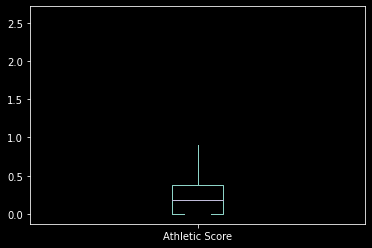

In [33]:
df["Athletic Score"].plot.box()

It looks like there's a clear winner ...

In [35]:
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt
df[["Neighborhood", "Athletic Score"]]

,Neighborhood,Athletic Score
31,Fairywood,2.586207
24,Duquesne Heights,0.915781
75,Squirrel Hill North,0.904059
79,Strip District,0.902527
57,Northview Heights,0.844595
...,...,...
56,North Shore,0.000000
59,Overbrook,0.000000
66,Ridgemont,0.000000
5,Banksville,0.000000


Fairywood blows everyone else out of the waters.... It isn't particularly close either.

In [36]:
# # import dataset
# steps = pd.read_csv("steps.csv")
# # filter to important info
# num_steps = steps.groupby("neighborhood").sum()['number_of_steps']
# num_steps.sort_values(ascending=False)

In [37]:
# # do the merge
# steps_map = neighborhoods.merge(num_steps, how='left', left_on='hood', right_on='neighborhood')
# # look at the head to confirm it merged correctly
# steps_map[['hood','number_of_steps','geometry']].head()

In [42]:
neighborhoods = geopandas.read_file("./data/Neighborhoods/Neighborhoods_.shp")

In [40]:
result = neighborhoods.merge(df, how='left', left_on='hood', right_on='Neighborhood')
result[["Neighborhood", "Athletic Score"]]

,Neighborhood,Athletic Score
0,Central Oakland,0.119570
1,North Oakland,0.439464
2,West Oakland,0.000000
3,Crawford-Roberts,0.000000
4,Strip District,0.902527
...,...,...
85,Ridgemont,0.000000
86,West End,0.000000
87,California-Kirkbride,0.000000
88,Glen Hazel,0.000000


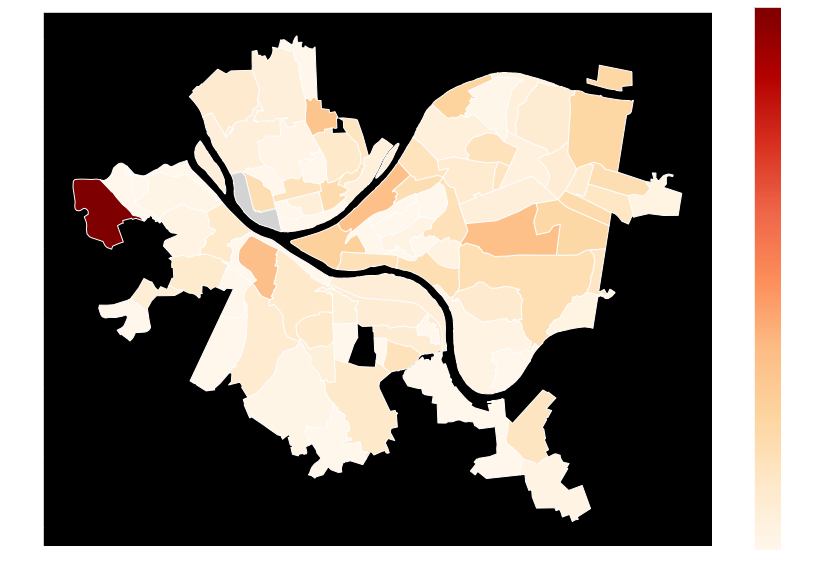

In [41]:
result.plot(column='Athletic Score', # set the data to be used for coloring
               cmap='OrRd',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Steps"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )